# The material presented in this jupyter notebook is part of the "ECE 685: Introduction to Deep Learning" course offered at Duke University.

# Session: Fall 2020

# Part 9: Generative Models - 2

## Generative Adversarial Network (GAN) 


<img src="GAN.jpg" width=600 height=400 />

In the vanilla-GAN we have,

* G(z): Generated image using the noise z. The images generated are called "fake samples".
* D(x): Probability of image being real, $0 \leq D(x) \leq 1$.
    * Discriminator tries to increase D(x) and decrease D(G(z)).
    * Generator tries to increase D(G(z)).

Discriminator optimization criterion:

$$\max_D \mathbb{E}_{x \sim p(x)} \log(D(x)) + \mathbb{E}_{z \sim p(z)} \log{(1-D(G(z)))}$$

Generator optimization criterion:

$$ \max_{G} \mathbb{E}_{z \sim p(z)} \log{(D(G(z)))}$$

### Reading Material: Please see Lecture Notes 16

**Generative Adversarial Networks**, introduced by Ian Goodfellow in 2014, are neural nets we can train to produce new images (or other kinds of data) that look as though they came from our true data distribution. In this notebook, we'll implement a small GAN for generating images that look as though they come from the MNIST dataset.The key insight behind the GAN is to pit two neural networks against each other. On the one hand is the Generator, a neural network that takes random noise as input and produces an image as output. On the other hand is the Discriminator, which takes in an image and classifies it as real (from MNIST) or fake (from our Generator). During training, we alternate between training the Generator to fool the Discriminator, and training the Discriminator to call the Generator's bluff.Implementing a GAN in Pytorch will give you practice turning more involved models into working code.

with special acknowledgement from https://github.com/eriklindernoren/PyTorch-GAN#gan

## Imports

In [1]:
%matplotlib inline
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

## Loading the data, MNIST

In [2]:
os.makedirs("images", exist_ok=True)

n_epochs = 200 # number of epochs of training
batch_size = 64 # size of the batches
n_cpu = 8 # number of cpu threads to use during batch generation

# Adam parameters
lr = 0.0002 # adam: learning rate
b1 = 0.5 # adam: decay of first order momentum of gradient
b2 = 0.999 # adam: decay of first order momentum of gradient

latent_dim = 100 # dimensionality of the latent space
img_size = 28 # size of each image dimension
channels = 1 # number of image channels
sample_interval = 500 # interval betwen image samples
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

## Generator

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

## Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

##  Training a GAN

In [5]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("./data", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# transform: -1 <= (x - 0.5) / 0.5 <= 1

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()) )
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

torch.Size([64, 1, 28, 28])
[Epoch 0/200] [Batch 0/938] [D loss: 0.698510] [G loss: 0.698147]
[Epoch 0/200] [Batch 500/938] [D loss: 0.615124] [G loss: 1.935611]
[Epoch 1/200] [Batch 62/938] [D loss: 0.407632] [G loss: 1.313027]
[Epoch 1/200] [Batch 562/938] [D loss: 0.324882] [G loss: 1.080711]
[Epoch 2/200] [Batch 124/938] [D loss: 0.219278] [G loss: 1.877718]
[Epoch 2/200] [Batch 624/938] [D loss: 0.257804] [G loss: 1.329453]
[Epoch 3/200] [Batch 186/938] [D loss: 0.554176] [G loss: 0.467999]
[Epoch 3/200] [Batch 686/938] [D loss: 0.152397] [G loss: 2.708116]
[Epoch 4/200] [Batch 248/938] [D loss: 0.269892] [G loss: 2.983062]
[Epoch 4/200] [Batch 748/938] [D loss: 0.442617] [G loss: 3.374259]
[Epoch 5/200] [Batch 310/938] [D loss: 0.373200] [G loss: 0.785662]
[Epoch 5/200] [Batch 810/938] [D loss: 0.300736] [G loss: 2.136907]
[Epoch 6/200] [Batch 372/938] [D loss: 0.368537] [G loss: 1.462092]
[Epoch 6/200] [Batch 872/938] [D loss: 0.286918] [G loss: 1.617652]
[Epoch 7/200] [Batch 43

### Traning Progress

In [21]:
from IPython.display import HTML, display
display(HTML("""<table><tr><td><img src='images/0.png'></td>
                <td><img src='images/2000.png'></td>
                <td><img src='images/4000.png'></td>
                <td><img src='images/6000.png'></td>
                <td><img src='images/8000.png'></td></tr>
                <tr><td><img src='images/10000.png'></td>
                <td><img src='images/12000.png'></td>
                <td><img src='images/14000.png'></td>
                <td><img src='images/16000.png'></td>
                <td><img src='images/18000.png'></td></tr>
                <tr><td><img src='images/20000.png'></td>
                <td><img src='images/22000.png'></td>
                <td><img src='images/24000.png'></td>
                <td><img src='images/26000.png'></td>
                <td><img src='images/28000.png'></td></tr>
                </table>"""))

,,,,
,,,,
,,,,


In [7]:
with torch.no_grad():
    z = Variable(Tensor(np.random.normal(0, 1, (128, latent_dim))))
    gen_imgs = generator(z)

torch.Size([128, 1, 28, 28])

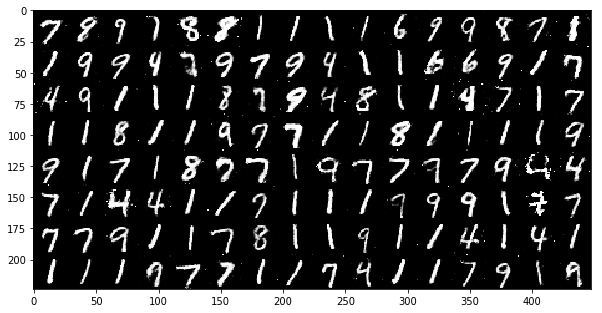

In [13]:
img = make_grid(gen_imgs, padding=0, nrow=16)
npimg = (img.cpu().numpy() * 0.5) + 0.5
    
fig, axes = plt.subplots(1,1, figsize=(10,10))
axes.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
fig.show()